# Visualize Data #
Visualize correlations between nodes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
print(dat['pupilCOM'].shape)

(7018, 2)


Text(0.5, 1.0, 'Pupil tracking')

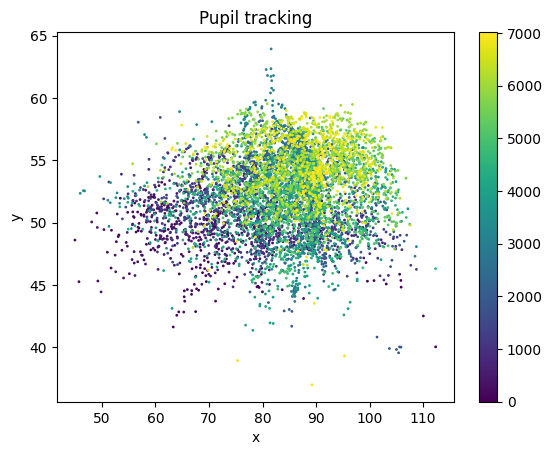

In [16]:
pupil_x_coords = dat['pupilCOM'][:,0]
pupil_y_coords = dat['pupilCOM'][:,1]
#Plot the data, where the color of the dot becomes darker as time progresses
plt.scatter(pupil_x_coords, pupil_y_coords, c=np.arange(len(pupil_x_coords)), cmap='viridis', s=1)
#Plot a colorbar to show the time progression
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Pupil tracking')

# plt.plot(pupil_x_coords, pupil_y_coords, '.')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Pupil tracking')

In [12]:
print((pupil_x_coords < 80).sum())
print((pupil_x_coords > 85).sum())
print(len(pupil_x_coords))

2120
3719
7018


## Building Graph Connectivity ##

In [20]:
import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx

In [5]:
neuron_data = dat['sresp']

In [94]:
neuron_data.shape

(11983, 7018)

In [21]:
#Filter the neuron data with a backwards-looking window of 20 frames
frame_size = 20
neuron_data_filtered = scipy.ndimage.uniform_filter1d(neuron_data, frame_size, axis=-1, mode='nearest', origin=-frame_size//2)

In [22]:
corr_matrix = np.corrcoef(neuron_data_filtered).round(decimals=4)

In [42]:
corr_matrix.shape

(11983, 11983)

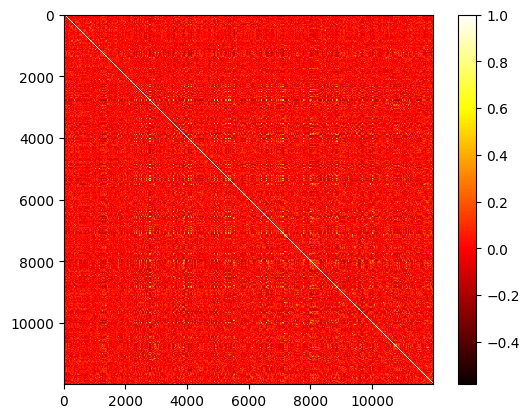

In [23]:
#Plot correlation matrix
plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
#Include colorbar
plt.colorbar()

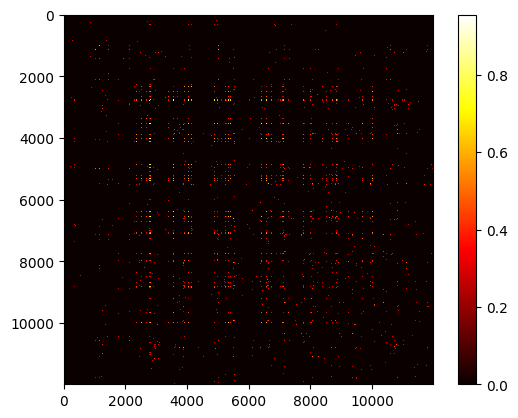

In [24]:
#Find the largest 2%, positive, non-diagonal correlations
corr_matrix[np.diag_indices_from(corr_matrix)] = 0
corr_matrix[corr_matrix < 0] = 0

# NOTE: Since the correlation matrix is symmetric, we must take the top 10% of the values
# in the entire matrix to get the top 10% of the connections
corr_matrix[corr_matrix < np.percentile(corr_matrix, 99)] = 0

plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

True
(11983, 7018)
(11372, 7018)
(11983, 11983)
(11372, 11372)


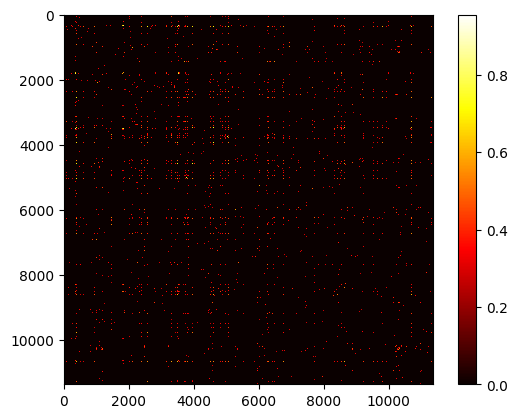

In [25]:
#Find the columns of the correlation matrix that have at least one nonzero value
nonzero_cols = np.where(corr_matrix.sum(axis=0) > 0)[0]

#Find the rows of the correlation matrix that have at least one nonzero value
nonzero_rows = np.where(corr_matrix.sum(axis=1) > 0)[0]

#Make sure that the nonzero rows and columns are the same
print(np.array_equal(nonzero_cols, nonzero_rows))

#Filter the neuron data to only include the neurons that have at least one nonzero correlation
compressed_neuron_data = neuron_data[nonzero_cols]

#Convert the correlation matrix to remove the rows and columns that are all zeros
compressed_corr_matrix = corr_matrix[nonzero_cols][:, nonzero_cols]


print(neuron_data.shape)
print(compressed_neuron_data.shape)
print(corr_matrix.shape)
print(compressed_corr_matrix.shape)

plt.imshow(compressed_corr_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

In [26]:
#Convert the correlation matrix to a list of graph edge connections in COO format
edges = np.nonzero(compressed_corr_matrix)
edge_index = torch.tensor(np.array([edges[0], edges[1]]), dtype=torch.long)

#Define the edge attributes as the correlation values between the neurons
edge_attr = torch.tensor(compressed_corr_matrix[edges], dtype=torch.float).unsqueeze(-1)

In [111]:
eligible_frames = np.where((pupil_x_coords < 75) | (pupil_x_coords > 85))[0]
print(pupil_x_coords[4])

90.89392566230129


In [33]:
#Define the node attributes as a vector containing the neuron's data for 20 preceding frames, including the current frame
frame_window = 20

#Find the frames where the pupil is looking either to the left or right and is greater than 20 frames from the beginning of the recording
eligible_frames = np.where((pupil_x_coords < 75) | (pupil_x_coords > 85))[0]
eligible_frames = eligible_frames[eligible_frames > frame_window]

curr_frame = eligible_frames[0]

node_attr = torch.tensor(compressed_neuron_data[:,curr_frame-frame_window:curr_frame+1], dtype=torch.float)

#Define the graph label as the current frame's direction of the pupil in the x direction
#If the x coordinate of the pupil is less than 75, the direction is left, denoted by 0
#If the x coordinate of the pupil is greater than 85, the direction is right, denoted by 1

curr_x_coord = pupil_x_coords[curr_frame]
if(curr_x_coord < 75):
  graph_label = torch.tensor([0], dtype=torch.float).unsqueeze(-1)
elif(curr_x_coord > 85):
    graph_label = torch.tensor([1], dtype=torch.float).unsqueeze(-1)
else:
    graph_label = torch.tensor([-1], dtype=torch.float).unsqueeze(-1)
    print("WARNING: Pupil located in the middle")

In [35]:
print(edge_index.shape)
print(max(edge_index[0]))
print(edge_attr.shape)
print(node_attr.shape)

torch.Size([2, 1436288])
tensor(11371)
torch.Size([1436288, 1])
torch.Size([11372, 21])


In [186]:
print(edge_index.max())
print(node_attr.shape)

tensor(11982)
torch.Size([11372, 21])


In [36]:
data = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, y=graph_label)

In [37]:
#Plot the edge connectivity of the nodes in the graph
#Produce a numpy array that iterates by 1 from 0 to 5 then by 5 from 5 to 300
num_connections = np.concatenate((np.arange(0, 5), np.arange(5, 300, 5)))
num_nodes = []

#Count the number of nodes in the graph that are not connected to any other nodes

for nc in num_connections:
    if(nc % 20 == 0):
        print("Working on %d connections" % nc)
    num_isolated_nodes = 0
    for i in range(data.num_nodes):
        if len(data.edge_index[0][data.edge_index[1] == i]) == nc:
            num_isolated_nodes += 1
    num_nodes.append(num_isolated_nodes)


Working on 0 connections
Working on 20 connections
Working on 40 connections
Working on 60 connections
Working on 80 connections
Working on 100 connections
Working on 120 connections
Working on 140 connections
Working on 160 connections
Working on 180 connections
Working on 200 connections
Working on 220 connections
Working on 240 connections
Working on 260 connections
Working on 280 connections


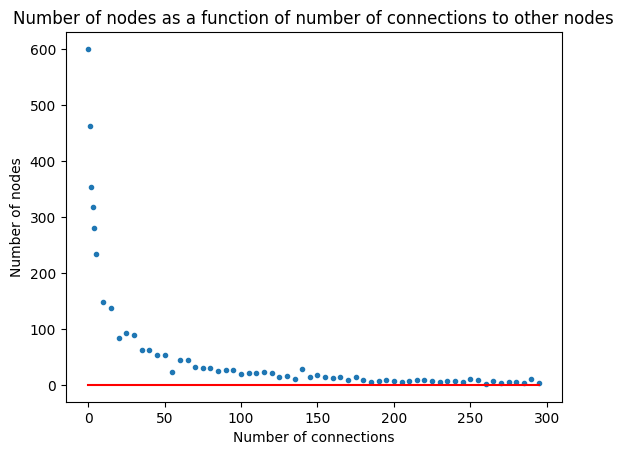

In [168]:
#Plot the number of nodes as a function of the number of connections to other nodes
plt.plot(num_connections, num_nodes, '.')
plt.xlabel('Number of connections')
plt.ylabel('Number of nodes')
plt.title('Number of nodes as a function of number of connections to other nodes')
#Overlay a line at y = 0
plt.plot(num_connections, np.zeros(len(num_connections)), 'r')

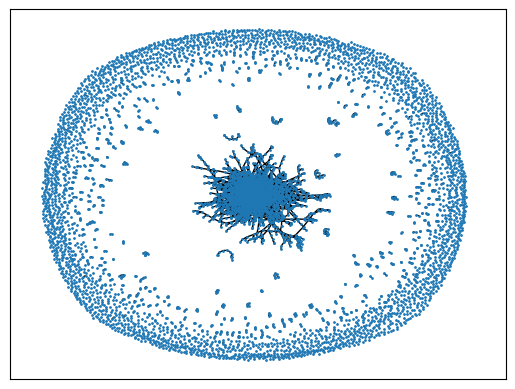

In [38]:
#Use networkx to visualize a sampled subset of the graph

import random
sample_size = 10000
sample_indices = random.sample(range(0, len(data.edge_index[0])), sample_size)
reduced_edge_index = data.edge_index[:,sample_indices]
reduced_edge_attr = data.edge_attr[sample_indices]

reduced_neuron_indices = np.unique(reduced_edge_index[0])
reduced_node_attr = torch.tensor(neuron_data[reduced_neuron_indices,curr_frame-frame_window:curr_frame+1], dtype=torch.float)

reduced_data = Data(x=reduced_node_attr, edge_index=reduced_edge_index, edge_attr=reduced_edge_attr, y=graph_label)

G = to_networkx(reduced_data, to_undirected=True)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_size=1, width=1)

#TODO: Augment the graph with a virtual node that is connected to all other nodes based on these results
#Have to be careful to not include the nodes that have nan values (those that are not referenced in edge_index)

In [124]:
print(edge_index.shape)
print(node_attr.shape)

torch.Size([2, 1436288])
torch.Size([11372, 21])


In [132]:
#Find the average node degree
avg_degree = round(edge_index.shape[-1]/node_attr.shape[0])
print(avg_degree)

126


Number of supernodes: 468
Average number of edges per supernode: 401


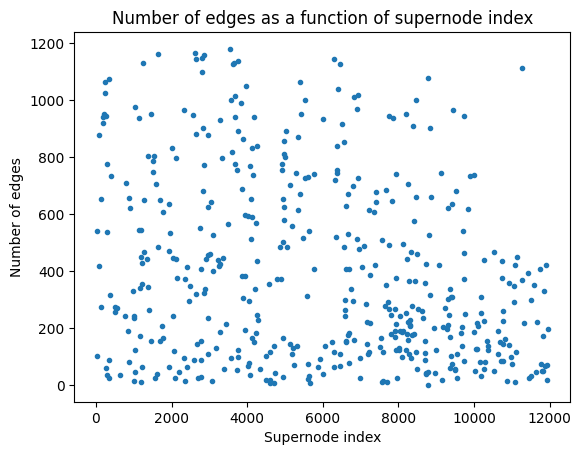

In [184]:
#Uniformly sample nodes from the graph based on the node degree
#These will be the "supernodes"
num_supernodes = 500
random_indices = np.random.choice(edge_index.shape[-1], size=num_supernodes, replace=False)
selected_nodes = edge_index[0,random_indices]

#remove duplicate nodes
selected_nodes = np.unique(selected_nodes)

print("Number of supernodes: %d" % len(selected_nodes))

#Count the number of edges that connect to each supernode
num_edges = []
for i in range(len(selected_nodes)):
    num_edges.append(len(edge_index[0][edge_index[0] == selected_nodes[i]]))

#TODO: Filter out supernodes that have below a minimum number of edges

#Plot the number of edges as a function of the number of connections to other nodes
plt.plot(selected_nodes, num_edges, '.')
plt.xlabel('Supernode index')
plt.ylabel('Number of edges')
plt.title('Number of edges as a function of supernode index')

#Calculate the average number of edges per supernode
avg_edges = round(np.mean(num_edges))
print("Average number of edges per supernode: %d" % avg_edges)

In [44]:
#Find the average and standard deviation of the positive values in the correlation matrix
avg_corr = np.mean(corr_matrix[corr_matrix > 0])
std_corr = np.std(corr_matrix[corr_matrix > 0])
#print(avg_corr, std_corr)

#Find the z-score of each value in the correlation matrix
z_score = (corr_matrix - avg_corr) / std_corr
#print(z_score.shape)

#Find the top 10% largest non-diagonal z-score values
z_score[np.diag_indices_from(z_score)] = 0
z_score = z_score.flatten()
z_score = np.sort(z_score)
z_score = z_score[int(len(z_score)*0.9):]
print(z_score)

[ 0.66513545  0.66513545  0.66513545 ... 12.67751275 12.68759992
 12.68759992]


In [26]:
print(z_score)

[ 0.26490881  0.26490881  0.26490881 ... 30.42112492 31.20440326
 31.20440326]
